HAR ANVÄNT MIG AV PREPROCESSING FRÅN samma fil som förra:

https://www.kaggle.com/code/amrabdellatif/brain-tumor-image-dataset-pytorch



och UNET från:

https://www.kaggle.com/code/wilbertch/mri-image-segmentation-unet




Andra att UNET undersöka som inte undersöks i denna notebook men som vi kan kolla på:

https://www.kaggle.com/code/moemnelhalose/brain-tumor-u-net-98

https://www.kaggle.com/code/nithunith/brain-tumor-unet



In [1]:
import os 
import glob
import json
import numpy as np
import cv2

In [2]:
train_path = "train"
valid_path = "valid"

In [3]:
train_data=[image for image in os.listdir(train_path)]


In [4]:
# creating mask from annotations
import json
import numpy as np
import skimage.draw
import tifffile
import os
import shutil
import matplotlib.pyplot as plt

def create_mask(image_info, annotations, output_folder, max_print=3):
    # Create an empty mask as a numpy array
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
#     print(mask_np.shape)

    # Counter for the object number
    object_number = 1

    printed_masks = 0  # Counter for the number of printed masks

    for ann in annotations:
        if ann['image_id'] == image_info['id']:
#             print(f"Processing annotation for image {image_info['file_name']}: {ann}")
            # Extract segmentation polygon
            for seg_idx, seg in enumerate(ann['segmentation']):
#                 print(f"Segmentation points: {seg}")
                # Convert polygons to a binary mask and add it to the main mask
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                # Create a mask for each segmentation
                seg_mask = np.zeros_like(mask_np, dtype=np.uint8)
                seg_mask[rr, cc] = 255  # Set the pixel values to 255 for the polygon
                # Save the segmentation mask
                mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
                tifffile.imwrite(mask_path, seg_mask)
#                 print(f"Saved segmentation mask for {image_info['file_name']} segment {seg_idx} to {mask_path}")
                
                # Print the segmentation mask using imshow
                # plt.imshow(seg_mask, cmap='gray')
                # plt.title(f"Segmentation Mask for {image_info['file_name']} Segment {seg_idx}")
                # plt.show()
                
                printed_masks += 1
                if printed_masks >= max_print:
                    return  # Exit the function if maximum number of masks to print is reached

#     print("All segmentation masks saved.")

In [5]:
# main function to create datasets
def main(json_file, mask_output_folder, image_output_folder, original_image_dir):
    # Load COCO JSON annotations
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']

    # Ensure the output directories exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)

    for img in images:
        # Create the masks
        create_mask(img, annotations, mask_output_folder)
        
        # Copy original images to the specified folder
        original_image_path = os.path.join(original_image_dir, img['file_name'])
    
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
        shutil.copy2(original_image_path, new_image_path)
#         print(f"Copied original image to {new_image_path}")

In [6]:
# ONLY NEEDED ONCE: Calling main function to create datasets 

# original_image_dir = 'test'  # Where your original images are stored
# json_file = 'test/_annotations.coco.json'
# mask_output_folder = 'test2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
# image_output_folder = 'test2/images'  # 
# main(json_file, mask_output_folder, image_output_folder, original_image_dir)


# original_image_dir = 'train'  # Where your original images are stored
# json_file = 'train/_annotations.coco.json'
# mask_output_folder = 'train2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
# image_output_folder = 'train2/images'  # 
# main(json_file, mask_output_folder, image_output_folder, original_image_dir)

# original_image_dir = 'valid'  # Where your original images are stored
# json_file = 'valid/_annotations.coco.json'
# mask_output_folder = 'valid2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
# image_output_folder = 'valid2/images'  # 
# main(json_file, mask_output_folder, image_output_folder, original_image_dir)

"I found a problem within train dataset .. there's an image that doesnt have a corresponding mask so im making a function to search and grab that file and delete it"

In [7]:
# import os

# def compare_folders_and_delete(folder1_path, folder2_path):
#     folder1_items = os.listdir(folder1_path)
#     folder2_items = os.listdir(folder2_path)

#     for item1 in folder1_items:
#         found = False
#         for item2 in folder2_items:
#             if item1[:4] == item2[:4]:
#                 found = True
#                 break
#         if not found:
#             print(f"Corresponding item for {item1} not found.")
#             item1_path = os.path.join(folder1_path, item1)
#             os.remove(item1_path)
#             print(f"Deleted {item1}")

#     for item2 in folder2_items:
#         found = False
#         for item1 in folder1_items:
#             if item2[:4] == item1[:4]:
#                 found = True
#                 break
#         if not found:
#             print(f"Corresponding item for {item2} not found.")
#             item2_path = os.path.join(folder2_path, item2)
#             os.remove(item2_path)
#             print(f"Deleted {item2}")

# # Example usage:
# folder1_path = "train2/images"
# folder2_path = "train2/masks"
# compare_folders_and_delete(folder1_path, folder2_path)

In [53]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset_general(Dataset):
    def __init__(self, root_dir, transform=None, maskTransform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform
        self.maskTransform = maskTransform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Read image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        image_gray = image.convert("L")  # Convert to grayscale

        # Read corresponding mask
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            # Apply transformations
            image_gray = self.transform(image_gray)
            mask = self.maskTransform(mask)

        return image_gray, mask

# Define paths for train, validation, and test sets
train_path = "train2" 
valid_path = "valid2"
test_path = "test2"

# Define transformations
image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

mask_transform = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.clamp(0, 1))
])


# Create datasets
train_dataset = CustomDataset_general(train_path, transform=image_transform, maskTransform=mask_transform)
valid_dataset = CustomDataset_general(valid_path, transform=image_transform, maskTransform=mask_transform)
# test_dataset = CustomDataset_general(test_path, transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
x, y = next(iter(train_loader))
x.shape , y.shape , type(x) , type(y)

(torch.Size([32, 3, 224, 224]),
 torch.Size([32, 1, 224, 224]),
 torch.Tensor,
 torch.Tensor)

In [31]:
# lets take a look at the data inside dataloaders and make sure it within range of [0,1] 

# Assuming x is a tensor from your DataLoader
# x, y = next(iter(train_loader))
import torch
# Count number of ones and zeros in tensor x
num_ones = torch.eq(x, 1).sum().item()
num_zeros = x.numel() - num_ones

print("Number of ones in x:", num_ones)
print("Number of zeros in x:", num_zeros)

# Count number of ones and zeros in tensor y
num_ones = torch.eq(y, 1).sum().item()
num_zeros = y.numel() - num_ones

print("Number of ones in y:", num_ones)
print("Number of zeros in y:", num_zeros)

Number of ones in x: 257888
Number of zeros in x: 4559008
Number of ones in y: 44052
Number of zeros in y: 1561580


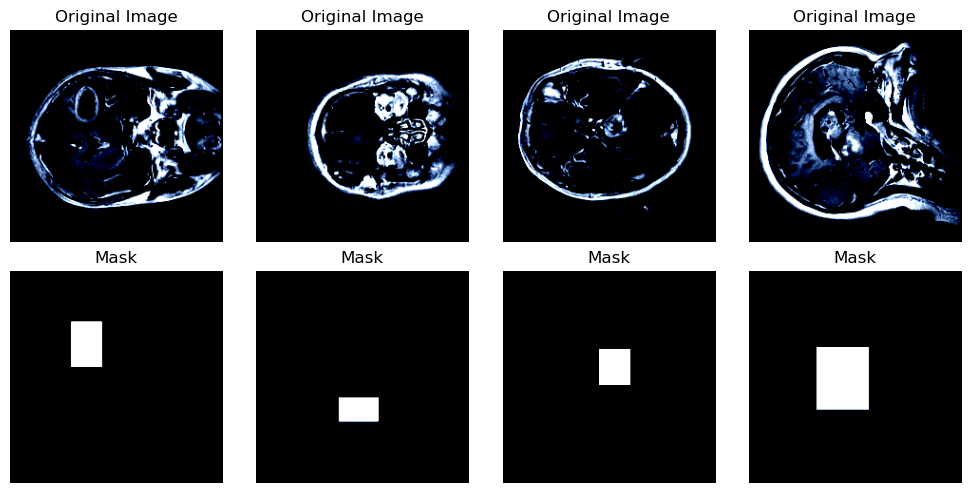

In [13]:
# Convert tensors to numpy arrays and permute dimensions if channels > 1
x_np = x.numpy().transpose(0, 2, 3, 1)  # Shape: (batch_size, height, width, channels)
y_np = y.numpy().transpose(0, 2, 3, 1)

# Plot the images
plt.figure(figsize=(10, 5))

# Plot original images
for i in range(4):
    plt.subplot(2, 4, i + 1)
    if x_np.shape[-1] == 1:  # If grayscale
        plt.imshow(x_np[i].squeeze(), cmap='gray')
    else:  # If multi-channel (e.g., RGB)
        plt.imshow(x_np[i])
    plt.title('Original Image')
    plt.axis('off')

# Plot masks
for i in range(4):
    plt.subplot(2, 4, i + 5)
    if y_np.shape[-1] == 1:  # If grayscale
        plt.imshow(y_np[i].squeeze(), cmap='gray')
    else:  # If multi-channel
        plt.imshow(y_np[i])
    plt.title('Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


HÄRIFRÅN OCH NER ÄR TAGET FRÅN https://www.kaggle.com/code/wilbertch/mri-image-segmentation-unet // Richard

In [14]:
import torch
from torchvision import datasets
from torchmetrics.classification import JaccardIndex
from torch.utils.data import Dataset ,DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.optim import lr_scheduler

UNET VERKAR ANVÄNDA DICE LOSS SOM ÄR NGN FÖRBÄTTRING AV crossentropy loss https://cvinvolution.medium.com/dice-loss-in-medical-image-segmentation-d0e476eb486

In [48]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, y_pred, y_true):
        # Apply softmax if using class logits to get probabilities
        y_pred = torch.softmax(y_pred, dim=1)  # Convert to probabilities
        smooth = 1.0

        # Get the probabilities for the positive class
        y_pred_pos = y_pred[:, 1, :, :]  # Assuming class 1 is the positive class
        y_true = (y_true > 0).float()  # Convert mask to float (binary)

        intersection = (y_pred_pos * y_true).sum()
        dic_loss = 1 - (2.0 * intersection + smooth) / (y_pred_pos.sum() + y_true.sum() + smooth)

        return dic_loss


In [ ]:
from transformers import SegformerForSemanticSegmentation
import torch.nn.functional as F
from tqdm import tqdm

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512", 
    num_labels=2, 
    ignore_mismatched_sizes=True
)

In [70]:
def train(model, device, optimizer, loss_fn, loader):
    running_loss = 0.0
    model.train()
    
    for images, masks in tqdm(loader):  
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images).logits 
        outputs = F.interpolate(outputs, size=(224, 224), mode='bilinear', align_corners=False)
        
        true_masks = masks.squeeze(1)  # Shape: [32, 224, 224] (if masks were [32, 1, 224, 224])
        true_masks = true_masks.long()  
        
        loss = loss_fn(outputs, true_masks)  
        
        loss.backward() 
        optimizer.step()
        
        running_loss += loss.item()

    return running_loss/len(loader)

def valid(model, device, loss_fn, loader):
    running_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(loader):
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images).logits 
            outputs = F.interpolate(outputs, size=(224, 224), mode='bilinear', align_corners=False)
        
            true_masks = masks.squeeze(1)  
            true_masks = true_masks.long()  
            
            loss = loss_fn(outputs, true_masks) 
        
            running_loss +=loss.item()
    return running_loss/len(loader)

In [ ]:
def train_model(model, device, optimizer, loss_fn, epochs, train_loader, valid_loader):
    model.to(device)
    train_loss = []
    valid_loss = []
    for epoch in range(epochs):
        train_epoch_loss = train(model, device, optimizer, loss_fn, train_loader)
        valid_epoch_loss = valid(model, device, loss_fn, valid_loader)

        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        print(train_loss)
    
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_epoch_loss}, Validation Loss: {valid_epoch_loss}")

    return train_loss, valid_loss 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = DiceLoss()  

epochs = 10
train_loss, valid_loss  = train_model(model, device, optimizer, loss_fn, epochs, train_loader, valid_loader)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:22<00:00,  1.64s/it]


[0.2101233741070362]
Epoch [1/10], Training Loss: 0.2101233741070362, Validation Loss: 0.30032433782305035


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:22<00:00,  1.61s/it]


[0.2101233741070362, 0.1904077910362406]
Epoch [2/10], Training Loss: 0.1904077910362406, Validation Loss: 0.3011957449572427


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:22<00:00,  1.62s/it]


[0.2101233741070362, 0.1904077910362406, 0.18630405182534077]
Epoch [3/10], Training Loss: 0.18630405182534077, Validation Loss: 0.30111079130853924


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:22<00:00,  1.61s/it]


[0.2101233741070362, 0.1904077910362406, 0.18630405182534077, 0.17497570337133206]
Epoch [4/10], Training Loss: 0.17497570337133206, Validation Loss: 0.30070618646485464


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:23<00:00,  1.67s/it]


[0.2101233741070362, 0.1904077910362406, 0.18630405182534077, 0.17497570337133206, 0.16923212117337166]
Epoch [5/10], Training Loss: 0.16923212117337166, Validation Loss: 0.2950942175728934


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:23<00:00,  1.64s/it]


[0.2101233741070362, 0.1904077910362406, 0.18630405182534077, 0.17497570337133206, 0.16923212117337166, 0.1588913468604392]
Epoch [6/10], Training Loss: 0.1588913468604392, Validation Loss: 0.3045768780367715


 28%|██████████████████████▋                                                           | 13/47 [01:14<03:12,  5.67s/it]

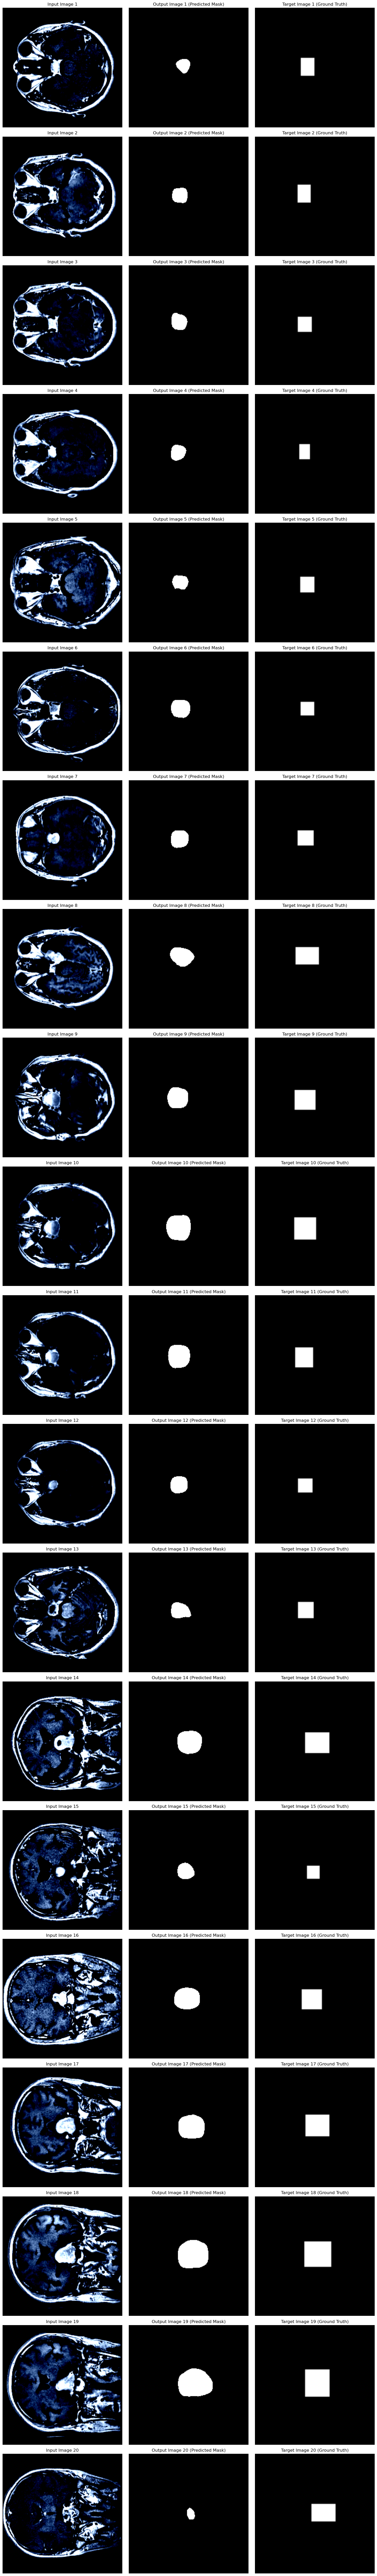

In [62]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize_input_output_target(input_images, output_images, target_images, num_samples=3):
    # Move tensors to CPU memory if they are on CUDA devices
    input_images = input_images.cpu()
    output_images = output_images.cpu()
    target_images = target_images.cpu()

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Plot input image
        axes[i, 0].imshow(input_images[i].permute(1, 2, 0).numpy())  # Assuming input has 3 channels
        axes[i, 0].set_title(f'Input Image {i + 1}')
        axes[i, 0].axis('off')

        # Plot output image (predicted binary mask)
        axes[i, 1].imshow(output_images[i][1].squeeze().numpy(), cmap='gray')  # Display the predicted foreground mask (channel 1)
        axes[i, 1].set_title(f'Output Image {i + 1} (Predicted Mask)')
        axes[i, 1].axis('off')

        # Plot target image (ground truth binary mask)
        axes[i, 2].imshow(target_images[i].squeeze().numpy(), cmap='gray')
        axes[i, 2].set_title(f'Target Image {i + 1} (Ground Truth)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()
    fig.savefig("output_multiple.png")

# Visualization after training
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    for batch, (X, y) in enumerate(valid_loader):
        X = X.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        # Forward pass
        y_pred_logits = model(X).logits
        
        # Resize outputs to match the true masks size
        y_pred_logits = F.interpolate(y_pred_logits, size=(224, 224), mode='bilinear', align_corners=False)

        # Convert logits to binary
        y_pred_binary = (torch.sigmoid(y_pred_logits) > 0.5).float()

        # Visualize the first few images in the batch
        num_samples =  # Set the number of samples you want to visualize
        visualize_input_output_target(X[:num_samples], y_pred_binary[:num_samples], y[:num_samples], num_samples)
        break  # Exit after visualizing the first batch
